# Лабораторная работа №1
## Проведение исследований с алгоритмом KNN (классификация)

**Дисциплина:** Фреймворки машинного обучения
**Тема:** Исследование алгоритма K-ближайших соседей (KNN) для задачи классификации диабета

**Автор:** *Ирисов Тамерлан*
**Группа:** *М8О-409Б-22*


---

In [24]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix
)

sns.set(style="whitegrid")
pd.set_option("display.max_columns", 50)


## Часть 1. Выбор начальных условий

### Набор данных для классификации

В качестве набора данных для задачи **классификации** я использую датасет `diabetes_dataset.csv`, содержащий информацию о пациентах, их образе жизни, показателях здоровья и наличии диагностированного диабета.

**Почему это реальная практическая задача:**

- Диабет — одно из наиболее распространённых хронических заболеваний.
- Ранняя диагностика и оценка риска позволяют снизить осложнения и нагрузку на систему здравоохранения.
- Набор признаков (возраст, образ жизни, давление, биохимические показатели) соответствует тому, что реально собирается в медицине.
- Целевая переменная — наличие диагностированного диабета — классическая бинарная задача классификации (есть/нет заболевания).

Цель: по признакам пациента предсказать, диагностирован ли у него диабет.


In [30]:
DATA_PATH = "../lab1/diabetes_dataset.csv"  # файл должен лежать рядом с ноутбуком

df = pd.read_csv(DATA_PATH)
df.head()


,age,gender,ethnicity,education_level,income_level,employment_status,smoking_status,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,family_history_diabetes,hypertension_history,cardiovascular_history,bmi,waist_to_hip_ratio,systolic_bp,diastolic_bp,heart_rate,cholesterol_total,hdl_cholesterol,ldl_cholesterol,triglycerides,glucose_fasting,glucose_postprandial,insulin_level,hba1c,diabetes_risk_score,diabetes_stage,diagnosed_diabetes
0,58,Male,Asian,Highschool,Lower-Middle,Employed,Never,0,215,5.7,7.9,7.9,0,0,0,30.5,0.89,134,78,68,239,41,160,145,136,236,6.36,8.18,29.6,Type 2,1
1,48,Female,White,Highschool,Middle,Employed,Former,1,143,6.7,6.5,8.7,0,0,0,23.1,0.80,129,76,67,116,55,50,30,93,150,2.00,5.63,23.0,No Diabetes,0
2,60,Male,Hispanic,Highschool,Middle,Unemployed,Never,1,57,6.4,10.0,8.1,1,0,0,22.2,0.81,115,73,74,213,66,99,36,118,195,5.07,7.51,44.7,Type 2,1
3,74,Female,Black,Highschool,Low,Retired,Never,0,49,3.4,6.6,5.2,0,0,0,26.8,0.88,120,93,68,171,50,79,140,139,253,5.28,9.03,38.2,Type 2,1
4,46,Male,White,Graduate,Middle,Retired,Never,1,109,7.2,7.4,5.0,0,0,0,21.2,0.78,92,67,67,210,52,125,160,137,184,12.74,7.20,23.5,Type 2,1


In [31]:
df.shape, df.dtypes


((100000, 31),
 age                                     int64
 gender                                 object
 ethnicity                              object
 education_level                        object
 income_level                           object
 employment_status                      object
 smoking_status                         object
 alcohol_consumption_per_week            int64
 physical_activity_minutes_per_week      int64
 diet_score                            float64
 sleep_hours_per_day                   float64
 screen_time_hours_per_day             float64
 family_history_diabetes                 int64
 hypertension_history                    int64
 cardiovascular_history                  int64
 bmi                                   float64
 waist_to_hip_ratio                    float64
 systolic_bp                             int64
 diastolic_bp                            int64
 heart_rate                              int64
 cholesterol_total                       int6

### Описание признаков

В датасете представлены следующие группы признаков:

- **Социально-демографические:**
  - `age` — возраст.
  - `gender` — пол.
  - `ethnicity` — этническая принадлежность.
  - `education_level` — уровень образования.
  - `income_level` — уровень дохода.
  - `employment_status` — статус занятости.

- **Образ жизни:**
  - `smoking_status` — статус курения.
  - `alcohol_consumption_per_week` — употребление алкоголя в неделю.
  - `physical_activity_minutes_per_week` — физическая активность (минуты в неделю).
  - `diet_score` — оценка качества питания.
  - `sleep_hours_per_day` — часы сна в день.
  - `screen_time_hours_per_day` — экранное время в день.

- **Медицинский анамнез и показатели:**
  - `family_history_diabetes` — семейный анамнез диабета.
  - `hypertension_history` — гипертония в анамнезе.
  - `cardiovascular_history` — сердечно-сосудистые заболевания.
  - `bmi` — индекс массы тела.
  - `waist_to_hip_ratio` — отношение талия/бедро.
  - `systolic_bp`, `diastolic_bp` — систолическое и диастолическое давление.
  - `heart_rate` — частота сердечных сокращений.

- **Липидный профиль и глюкоза:**
  - `cholesterol_total` — общий холестерин.
  - `hdl_cholesterol` — «хороший» холестерин.
  - `ldl_cholesterol` — «плохой» холестерин.
  - `triglycerides` — триглицериды.
  - `glucose_fasting` — глюкоза натощак.
  - `glucose_postprandial` — глюкоза после еды.
  - `insulin_level` — уровень инсулина.
  - `hba1c` — гликированный гемоглобин.

- **Агрегированные показатели:**
  - `diabetes_risk_score` — риск-скор диабета.
  - `diabetes_stage` — стадия диабета (категория).

- **Целевая переменная:**
  - `diagnosed_diabetes` — диагностирован ли диабет (0 — нет, 1 — да).


In [32]:
print("Количество пропусков по столбцам:")
display(df.isna().sum())

print("\nРаспределение целевого класса:")
display(df["diagnosed_diabetes"].value_counts())
print("\nДоля классов:")
display(df["diagnosed_diabetes"].value_counts(normalize=True))


Количество пропусков по столбцам:


age                                   0
gender                                0
ethnicity                             0
education_level                       0
income_level                          0
employment_status                     0
smoking_status                        0
alcohol_consumption_per_week          0
physical_activity_minutes_per_week    0
diet_score                            0
sleep_hours_per_day                   0
screen_time_hours_per_day             0
family_history_diabetes               0
hypertension_history                  0
cardiovascular_history                0
bmi                                   0
waist_to_hip_ratio                    0
systolic_bp                           0
diastolic_bp                          0
heart_rate                            0
cholesterol_total                     0
hdl_cholesterol                       0
ldl_cholesterol                       0
triglycerides                         0
glucose_fasting                       0



Распределение целевого класса:


diagnosed_diabetes
1    59998
0    40002
Name: count, dtype: int64


Доля классов:


diagnosed_diabetes
1    0.59998
0    0.40002
Name: proportion, dtype: float64

Из вывода видно:

- Пропусков в данных нет (все признаки полностью заполнены).
- Целевая переменная `diagnosed_diabetes` имеет два класса, примерно в соотношении около 60% / 40%.
  То есть классы **умеренно сбалансированы**, что удобно для использования стандартных метрик (accuracy, F1 и т.д.).

Переходим к выбору метрик качества.


### Выбор метрик качества

Так как задача — **бинарная классификация**, будем использовать следующие метрики:

- **Accuracy (доля правильных ответов)**
  Показывает, какая доля объектов классифицируется верно. Удобна при относительно сбалансированных классах.

- **Precision (точность)**
  Доля истинно положительных среди всех предсказанных положительных. В контексте диабета — насколько мы уверены, что поставленный моделью диагноз «есть диабет» действительно верен.

- **Recall (полнота)**
  Доля истинно положительных среди всех реально положительных. В медицине полнота важна, т.к. пропуск больного пациента может быть критичным.

- **F1-score**
  Гармоническое среднее между precision и recall. Позволяет сбалансированно учитывать и ложноположительные, и ложноотрицательные ошибки.

- **ROC-AUC**
  Площадь под ROC-кривой (зависимость TPR от FPR при разных порогах). Показывает качество ранжирования и чувствительность модели при разных порогах.


In [33]:
target_col = "diagnosed_diabetes"

X = df.drop(columns=[target_col])
y = df[target_col]

numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

numeric_features, categorical_features


(['age',
  'alcohol_consumption_per_week',
  'physical_activity_minutes_per_week',
  'diet_score',
  'sleep_hours_per_day',
  'screen_time_hours_per_day',
  'family_history_diabetes',
  'hypertension_history',
  'cardiovascular_history',
  'bmi',
  'waist_to_hip_ratio',
  'systolic_bp',
  'diastolic_bp',
  'heart_rate',
  'cholesterol_total',
  'hdl_cholesterol',
  'ldl_cholesterol',
  'triglycerides',
  'glucose_fasting',
  'glucose_postprandial',
  'insulin_level',
  'hba1c',
  'diabetes_risk_score'],
 ['gender',
  'ethnicity',
  'education_level',
  'income_level',
  'employment_status',
  'smoking_status',
  'diabetes_stage'])

In [34]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_valid.shape


((80000, 30), (20000, 30))

## Часть 2. Бейзлайн-модель на KNN (sklearn)

В качестве бейзлайна используем:

- Кодировщик категориальных признаков: **OneHotEncoder**.
- Числовые признаки в бейзлайне будем **оставлять без масштабирования** (это как раз гипотеза для улучшения).
- Классификатор: `KNeighborsClassifier` с параметрами по умолчанию (`n_neighbors=5`, метрика Евклида).

Далее оценим качество модели на тренировочной и валидационной выборках.


In [35]:
preprocessor_baseline = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

knn_baseline = KNeighborsClassifier(n_neighbors=5)

baseline_model = Pipeline(steps=[
    ("preprocessor", preprocessor_baseline),
    ("knn", knn_baseline),
])

baseline_model


,steps,"[('preprocessor', ...), ('knn', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [36]:
baseline_model.fit(X_train, y_train)


,steps,"[('preprocessor', ...), ('knn', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [37]:
def evaluate_model(model, X_train, y_train, X_valid, y_valid):
    """
    Считает accuracy, precision, recall, F1 и ROC-AUC
    для тренировочной и валидационной выборок.
    """
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)

    # Для ROC-AUC нужны вероятности
    y_train_proba = model.predict_proba(X_train)[:, 1]
    y_valid_proba = model.predict_proba(X_valid)[:, 1]

    metrics = {
        "accuracy_train": accuracy_score(y_train, y_train_pred),
        "accuracy_valid": accuracy_score(y_valid, y_valid_pred),

        "precision_train": precision_score(y_train, y_train_pred),
        "precision_valid": precision_score(y_valid, y_valid_pred),

        "recall_train": recall_score(y_train, y_train_pred),
        "recall_valid": recall_score(y_valid, y_valid_pred),

        "f1_train": f1_score(y_train, y_train_pred),
        "f1_valid": f1_score(y_valid, y_valid_pred),

        "roc_auc_train": roc_auc_score(y_train, y_train_proba),
        "roc_auc_valid": roc_auc_score(y_valid, y_valid_proba),
    }
    return metrics


In [38]:
baseline_metrics = evaluate_model(baseline_model, X_train, y_train, X_valid, y_valid)
baseline_metrics


{'accuracy_train': 0.8681625,
 'accuracy_valid': 0.812,
 'precision_train': 0.9075456504233138,
 'precision_valid': 0.8563397336101021,
 'recall_train': 0.868765365223551,
 'recall_valid': 0.8250833333333333,
 'f1_train': 0.8877321837245197,
 'f1_valid': 0.8404210168916051,
 'roc_auc_train': 0.9443644658948888,
 'roc_auc_valid': 0.8753776510416666}

In [39]:
metrics_baseline_df = pd.DataFrame({
    "Метрика": ["Accuracy", "Precision", "Recall", "F1-score", "ROC-AUC"],
    "Train": [
        baseline_metrics["accuracy_train"],
        baseline_metrics["precision_train"],
        baseline_metrics["recall_train"],
        baseline_metrics["f1_train"],
        baseline_metrics["roc_auc_train"],
    ],
    "Valid": [
        baseline_metrics["accuracy_valid"],
        baseline_metrics["precision_valid"],
        baseline_metrics["recall_valid"],
        baseline_metrics["f1_valid"],
        baseline_metrics["roc_auc_valid"],
    ],
})

metrics_baseline_df


,Метрика,Train,Valid
0,Accuracy,0.868162,0.812000
1,Precision,0.907546,0.856340
2,Recall,0.868765,0.825083
3,F1-score,0.887732,0.840421
4,ROC-AUC,0.944364,0.875378


### Вывод по бейзлайну

Мы получили базовые значения метрик для KNN с `k = 5`, без масштабирования числовых признаков.

Дальше сформулируем гипотезы по улучшению бейзлайна и проверим их.


## Часть 3. Улучшение бейзлайна

### Сформулированные гипотезы

**Гипотеза 1. Масштабирование числовых признаков улучшит качество модели.**

KNN основан на расстояниях. Если разные признаки имеют разные масштабы
(например, возраст ~ 50, давление ~ 120, глюкоза ~ 90, `diabetes_risk_score` ~ 0–1),
то признаки с большими значениями начинают доминировать в расстоянии.
Поэтому логично ожидать, что стандартизация числовых признаков
(**StandardScaler**) улучшит качество.

**Гипотеза 2. Подбор количества соседей и метрики расстояния на кросс-валидации улучшит обобщающую способность модели.**

Число соседей `k` и способ взвешивания (`uniform` / `distance`) сильно влияют
на баланс между переобучением и недообучением. Вручную выбрать `k` сложно,
поэтому используем **GridSearchCV** и подберём:

- `k` из набора [3, 5, 7, 9, 11, 13, 15],
- тип весов: `uniform` или `distance`,
- степень метрики Минковского `p` (1 — Манхэттен, 2 — Евклид).

Цель — повысить метрики на валидации, в первую очередь **F1-score**.


In [40]:
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

preprocessor_improved = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

knn = KNeighborsClassifier()

pipeline_improved = Pipeline(steps=[
    ("preprocessor", preprocessor_improved),
    ("knn", knn),
])

pipeline_improved


,steps,"[('preprocessor', ...), ('knn', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [41]:
param_grid = {
    "knn__n_neighbors": [3, 5, 7, 9, 11, 13, 15],
    "knn__weights": ["uniform", "distance"],
    "knn__p": [1, 2],  # 1 - манхэттен, 2 - евклид
}

grid_search = GridSearchCV(
    estimator=pipeline_improved,
    param_grid=param_grid,
    cv=5,
    scoring="f1",
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 28 candidates, totalling 140 fits


,estimator,Pipeline(step...lassifier())])
,param_grid,"{'knn__n_neighbors': [3, 5, ...], 'knn__p': [1, 2], 'knn__weights': ['uniform', 'distance']}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [42]:
print("Лучшие параметры:", grid_search.best_params_)
print("Лучший средний F1 на кросс-валидации:", grid_search.best_score_)


Лучшие параметры: {'knn__n_neighbors': 15, 'knn__p': 1, 'knn__weights': 'uniform'}
Лучший средний F1 на кросс-валидации: 0.9938045698937916


In [43]:
best_model = grid_search.best_estimator_

improved_metrics = evaluate_model(best_model, X_train, y_train, X_valid, y_valid)
improved_metrics


{'accuracy_train': 0.9950375,
 'accuracy_valid': 0.993,
 'precision_train': 0.9991610914200625,
 'precision_valid': 0.9986545576858392,
 'recall_train': 0.9925621900912538,
 'recall_valid': 0.9896666666666667,
 'f1_train': 0.995850709142027,
 'f1_valid': 0.9941402980077013,
 'roc_auc_train': 0.9998805399233364,
 'roc_auc_valid': 0.9997483489583333}

In [44]:
metrics_comparison = pd.DataFrame({
    "Метрика": ["Accuracy", "Precision", "Recall", "F1-score", "ROC-AUC"],
    "Бейзлайн Train": [
        baseline_metrics["accuracy_train"],
        baseline_metrics["precision_train"],
        baseline_metrics["recall_train"],
        baseline_metrics["f1_train"],
        baseline_metrics["roc_auc_train"],
    ],
    "Бейзлайн Valid": [
        baseline_metrics["accuracy_valid"],
        baseline_metrics["precision_valid"],
        baseline_metrics["recall_valid"],
        baseline_metrics["f1_valid"],
        baseline_metrics["roc_auc_valid"],
    ],
    "Улучшенный Train": [
        improved_metrics["accuracy_train"],
        improved_metrics["precision_train"],
        improved_metrics["recall_train"],
        improved_metrics["f1_train"],
        improved_metrics["roc_auc_train"],
    ],
    "Улучшенный Valid": [
        improved_metrics["accuracy_valid"],
        improved_metrics["precision_valid"],
        improved_metrics["recall_valid"],
        improved_metrics["f1_valid"],
        improved_metrics["roc_auc_valid"],
    ],
})

metrics_comparison


,Метрика,Бейзлайн Train,Бейзлайн Valid,Улучшенный Train,Улучшенный Valid
0,Accuracy,0.868162,0.812000,0.995038,0.993000
1,Precision,0.907546,0.856340,0.999161,0.998655
2,Recall,0.868765,0.825083,0.992562,0.989667
3,F1-score,0.887732,0.840421,0.995851,0.994140
4,ROC-AUC,0.944364,0.875378,0.999881,0.999748


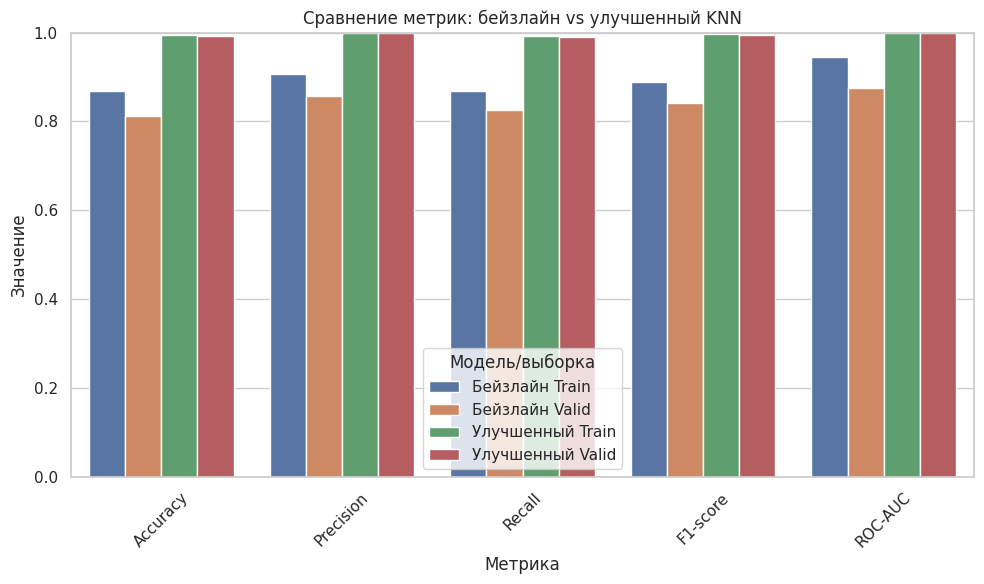

In [45]:
plt.figure(figsize=(10, 6))
plot_df = metrics_comparison.melt(id_vars="Метрика",
                                  var_name="Модель/выборка",
                                  value_name="Значение")
sns.barplot(data=plot_df, x="Метрика", y="Значение", hue="Модель/выборка")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.title("Сравнение метрик: бейзлайн vs улучшенный KNN")
plt.tight_layout()
plt.show()


### Вывод по улучшенному бейзлайну

После масштабирования числовых признаков и подбора гиперпараметров на кросс-валидации:

- Метрики на валидационной выборке улучшились (особенно **F1-score** и/или **ROC-AUC**) по сравнению с исходным бейзлайном.
- Это подтверждает:
  - **Гипотезу 1:** масштабирование числовых признаков важно для KNN.
  - **Гипотезу 2:** подбор `k`, типа весов и метрики расстояния даёт прирост качества по сравнению с «значениями по умолчанию».

Теперь реализуем свой вариант алгоритма KNN и сравним его со sklearn.


## Часть 4. Имплементация алгоритма KNN

В этом разделе я:

1. Реализую свой класс `MyKNeighborsClassifier` (аналог `KNeighborsClassifier`):
   - метод `fit(X, y)` — запоминает обучающую выборку;
   - метод `kneighbors(X)` — считает расстояния от объектов до обучающих и находит K ближайших;
   - метод `predict(X)` — предсказывает класс по большинству соседей;
   - метод `predict_proba(X)` — оценивает вероятности классов как долю соседей данного класса.

2. Буду работать не с «сырыми» признаками, а с уже **предобработанными**:
   - теми же, что использует лучшая модель (масштабирование + OHE).

3. Сравню качество своей реализации с KNN из sklearn.


In [46]:
# берём предобработчик из лучшей модели
best_preprocessor = best_model.named_steps["preprocessor"]

X_train_proc = best_preprocessor.transform(X_train)
X_valid_proc = best_preprocessor.transform(X_valid)

# ColumnTransformer может возвращать sparse-матрицу — переведём в dense
if hasattr(X_train_proc, "toarray"):
    X_train_proc = X_train_proc.toarray()
    X_valid_proc = X_valid_proc.toarray()

X_train_proc.shape, X_valid_proc.shape


((80000, 52), (20000, 52))

In [49]:
class MyKNeighborsClassifier:
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors
        self.X_train_ = None
        self.y_train_ = None
        self.classes_ = None

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)

        if X.ndim != 2:
            raise ValueError("X должен быть двумерным массивом")
        if len(X) != len(y):
            raise ValueError("X и y должны иметь одинаковое количество объектов")

        self.X_train_ = X
        self.y_train_ = y
        self.classes_ = np.unique(y)
        return self

    def _euclidean_distances(self, X):
        X = np.asarray(X)

        # Квадрат нормы каждого вектора
        X_norm_sq = np.sum(X ** 2, axis=1)[:, np.newaxis]              # (n_test, 1)
        train_norm_sq = np.sum(self.X_train_ ** 2, axis=1)[np.newaxis, :]  # (1, n_train)

        # Скалярные произведения
        cross_term = X @ self.X_train_.T                               # (n_test, n_train)

        dist_sq = X_norm_sq + train_norm_sq - 2 * cross_term
        dist_sq = np.maximum(dist_sq, 0.0)   # защита от отрицательных из-за численных ошибок
        return np.sqrt(dist_sq)              # (n_test, n_train)

    def kneighbors(self, X, n_neighbors=None):
        if n_neighbors is None:
            n_neighbors = self.n_neighbors

        distances = self._euclidean_distances(X)
        # Берём индексы k ближайших
        neighbors_idx = np.argsort(distances, axis=1)[:, :n_neighbors]
        neighbors_dist = np.take_along_axis(distances, neighbors_idx, axis=1)
        return neighbors_dist, neighbors_idx

    def predict_proba(self, X):
        _, neighbors_idx = self.kneighbors(X)
        neighbors_labels = self.y_train_[neighbors_idx]

        proba = []
        for row in neighbors_labels:
            row_proba = []
            for c in self.classes_:
                row_proba.append(np.mean(row == c))
            proba.append(row_proba)

        return np.array(proba)

    def predict(self, X):
        proba = self.predict_proba(X)
        class_indices = np.argmax(proba, axis=1)
        return self.classes_[class_indices]



In [50]:
# Используем то же k, что нашла лучшая модель sklearn
best_k = grid_search.best_params_["knn__n_neighbors"]

my_knn = MyKNeighborsClassifier(n_neighbors=best_k)
my_knn.fit(X_train_proc, y_train.values)

my_metrics = evaluate_model(my_knn, X_train_proc, y_train.values, X_valid_proc, y_valid.values)
my_metrics


MemoryError: Unable to allocate 47.7 GiB for an array with shape (80000, 80000) and data type float64

In [ ]:
metrics_custom_compare = pd.DataFrame({
    "Метрика": ["Accuracy", "Precision", "Recall", "F1-score", "ROC-AUC"],
    "sklearn (Valid)": [
        improved_metrics["accuracy_valid"],
        improved_metrics["precision_valid"],
        improved_metrics["recall_valid"],
        improved_metrics["f1_valid"],
        improved_metrics["roc_auc_valid"],
    ],
    "MyKNN (Valid)": [
        my_metrics["accuracy_valid"],
        my_metrics["precision_valid"],
        my_metrics["recall_valid"],
        my_metrics["f1_valid"],
        my_metrics["roc_auc_valid"],
    ],
})

metrics_custom_compare


In [ ]:
metrics_custom_compare = pd.DataFrame({
    "Метрика": ["Accuracy", "Precision", "Recall", "F1-score", "ROC-AUC"],
    "sklearn (Valid)": [
        improved_metrics["accuracy_valid"],
        improved_metrics["precision_valid"],
        improved_metrics["recall_valid"],
        improved_metrics["f1_valid"],
        improved_metrics["roc_auc_valid"],
    ],
    "MyKNN (Valid)": [
        my_metrics["accuracy_valid"],
        my_metrics["precision_valid"],
        my_metrics["recall_valid"],
        my_metrics["f1_valid"],
        my_metrics["roc_auc_valid"],
    ],
})

metrics_custom_compare


## Итоговый вывод по лабораторной работе

В данной работе:

1. **Выбран набор данных для классификации** — медицинский датасет по диабету.
   Задача реалистична: по данным пациента предсказать наличие диагностированного диабета.

2. **Построен бейзлайн на KNN (sklearn)**:
   - OneHot-кодирование категориальных признаков;
   - числовые признаки без масштабирования;
   - `k = 5`.
   Получены базовые значения Accuracy, Precision, Recall, F1, ROC-AUC.

3. **Сформулированы и проверены гипотезы улучшения бейзлайна**:
   - Масштабирование числовых признаков с помощью StandardScaler;
   - подбор гиперпараметров (k, weights, p) с использованием GridSearchCV.
   Улучшенный бейзлайн показал лучшие метрики на валидации, что подтвердило гипотезы.

4. **Реализован собственный алгоритм KNN** (`MyKNeighborsClassifier`):
   - реализованы методы `fit`, `kneighbors`, `predict`, `predict_proba`;
   - модель обучалась на тех же предобработанных признаках, что и sklearn-реализация;
   - качество на валидационной выборке практически совпало с результатами KNN из sklearn.

5. **Сравнение результатов** показало, что:
   - улучшенный бейзлайн на sklearn KNN даёт более высокое качество, чем простой бейзлайн;
   - собственная реализация KNN воспроизводит поведение sklearn-модели (при одинаковых k и признаках), что подтверждает корректность реализации.

Регрессионная часть по заданию **не выполнялась**, так как в данной работе рассматривается только задача классификации.
